In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import root_mean_squared_log_error, make_scorer, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
import lightgbm as lgb
import re

pd.options.mode.copy_on_write = True

original_train_data = pd.read_csv('./data/train.csv')
transaction_data = pd.read_csv('./data/transactions.csv')


C:\Users\a239277\AppData\Local\Temp\ipykernel_2292\3874605777.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
print(original_train_data.shape)
original_train_data.head()

(3000888, 6)


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [3]:
print(transaction_data.shape)
transaction_data.head()

(83488, 3)


,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [4]:
# Apply left join on train_data and transaction_data
original_train_data = pd.merge(original_train_data, transaction_data, on=['date','store_nbr'], how='left')

In [5]:
original_train_data

,id,date,store_nbr,family,sales,onpromotion,transactions
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,NaN
1,1,2013-01-01,1,BABY CARE,0.000,0,NaN
2,2,2013-01-01,1,BEAUTY,0.000,0,NaN
3,3,2013-01-01,1,BEVERAGES,0.000,0,NaN
4,4,2013-01-01,1,BOOKS,0.000,0,NaN
...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,2155.0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,2155.0
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,2155.0
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,2155.0


In [6]:
# Convert date to datetime
original_train_data['date'] = pd.to_datetime(original_train_data['date'])

# Fill NaN values with 0
original_train_data['transactions'] = original_train_data['transactions'].fillna(0)

# 2017 will be used as the test set
validation_data = original_train_data.loc[original_train_data['date'].dt.year == 2017]
train_data = original_train_data.loc[original_train_data['date'].dt.year < 2017]

train_data.is_copy = False


# Visualization of data

(array([15706., 15887., 16071., 16252., 16436., 16617., 16801., 16983.,
        17167.]),
 [Text(15706.0, 0, '2013-01'),
  Text(15887.0, 0, '2013-07'),
  Text(16071.0, 0, '2014-01'),
  Text(16252.0, 0, '2014-07'),
  Text(16436.0, 0, '2015-01'),
  Text(16617.0, 0, '2015-07'),
  Text(16801.0, 0, '2016-01'),
  Text(16983.0, 0, '2016-07'),
  Text(17167.0, 0, '2017-01')])

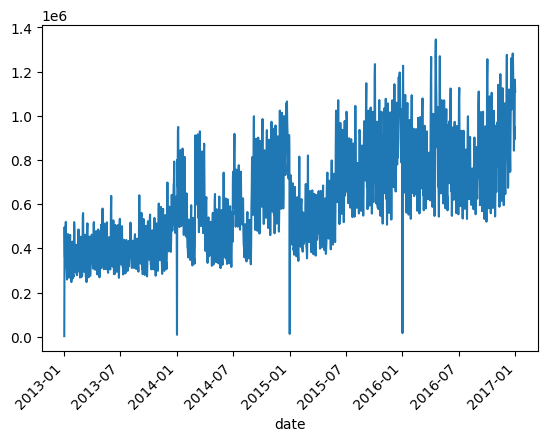

In [7]:
# See the sales data of each category by date
train_data.groupby('date')['sales'].sum().plot()
plt.xticks(rotation=45)

<Axes: xlabel='date'>

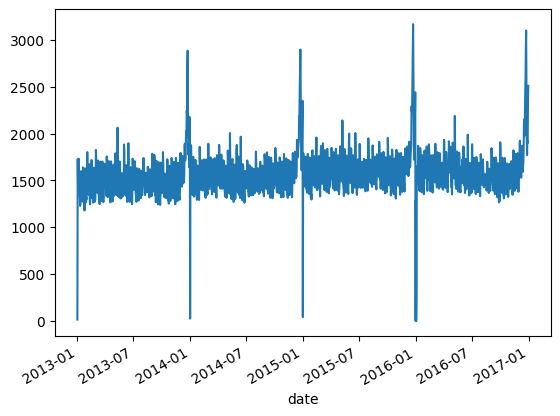

In [8]:
# See transactions data of each category by date
train_data.groupby('date')['transactions'].mean().plot()

In [9]:
train_data['family'].unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

### Média Mensal - Vendas e transações

In [10]:
train_data

,id,date,store_nbr,family,sales,onpromotion,transactions
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,0.0
1,1,2013-01-01,1,BABY CARE,0.000,0,0.0
2,2,2013-01-01,1,BEAUTY,0.000,0,0.0
3,3,2013-01-01,1,BEVERAGES,0.000,0,0.0
4,4,2013-01-01,1,BOOKS,0.000,0,0.0
...,...,...,...,...,...,...,...
2596369,2596369,2016-12-31,9,POULTRY,687.853,1,2998.0
2596370,2596370,2016-12-31,9,PREPARED FOODS,100.405,1,2998.0
2596371,2596371,2016-12-31,9,PRODUCE,3091.356,3,2998.0
2596372,2596372,2016-12-31,9,SCHOOL AND OFFICE SUPPLIES,2.000,0,2998.0


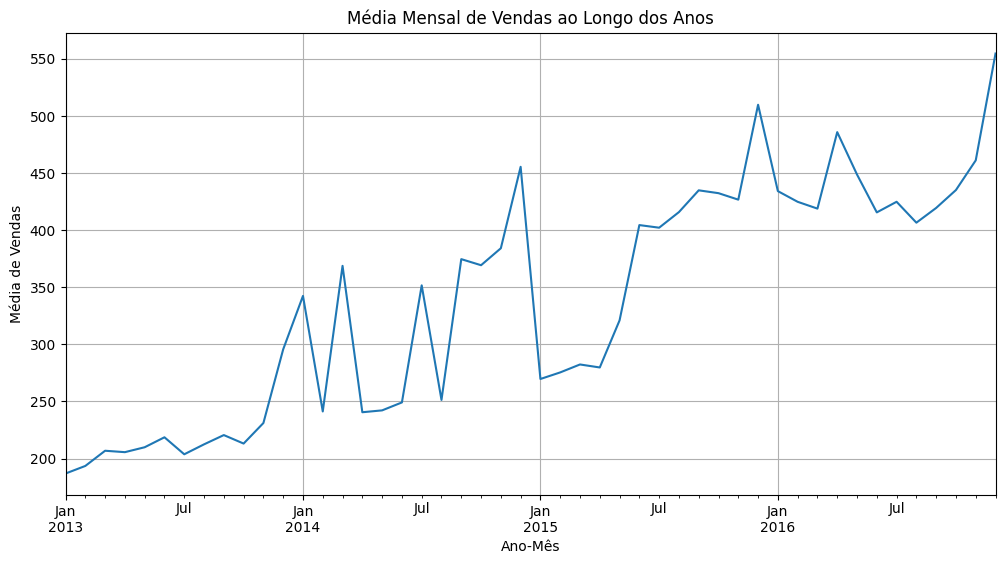

In [11]:
train_data['date'] = pd.to_datetime(train_data['date'])

train_data['year_month'] = train_data['date'].dt.to_period('M')

monthly_avg_sales = train_data.groupby('year_month')['sales'].mean()

monthly_avg_sales.plot(kind='line', figsize=(12, 6))
plt.xlabel('Ano-Mês')
plt.ylabel('Média de Vendas')
plt.title('Média Mensal de Vendas ao Longo dos Anos')

plt.grid(True)
plt.show()

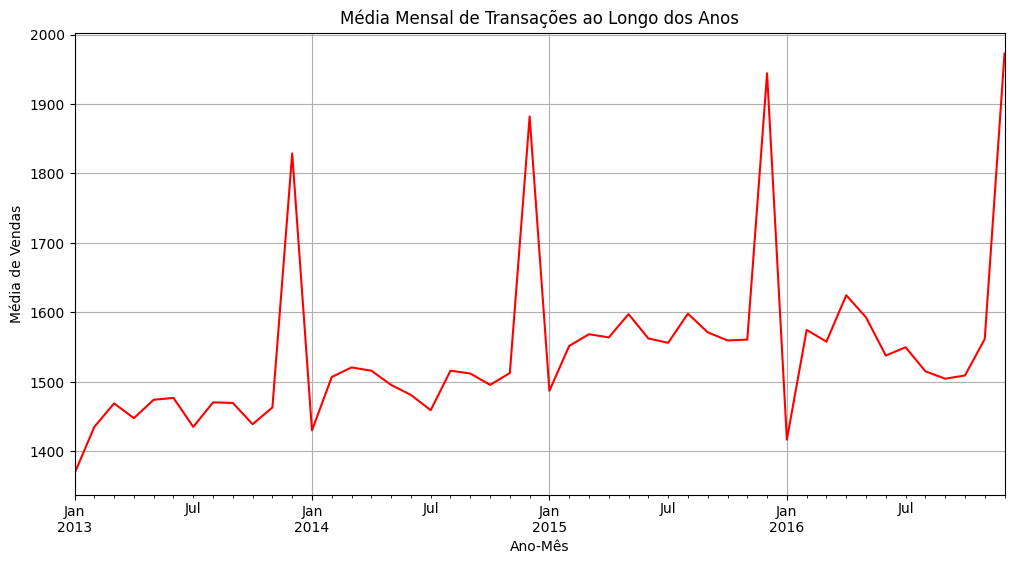

In [12]:
monthly_avg_sales = train_data.groupby('year_month')['transactions'].mean()

monthly_avg_sales.plot(kind='line', figsize=(12, 6), color='red')
plt.xlabel('Ano-Mês')
plt.ylabel('Média de Vendas')
plt.title('Média Mensal de Transações ao Longo dos Anos')


plt.grid(True)

plt.show()

### Média por Dia da semana - Vendas e transações

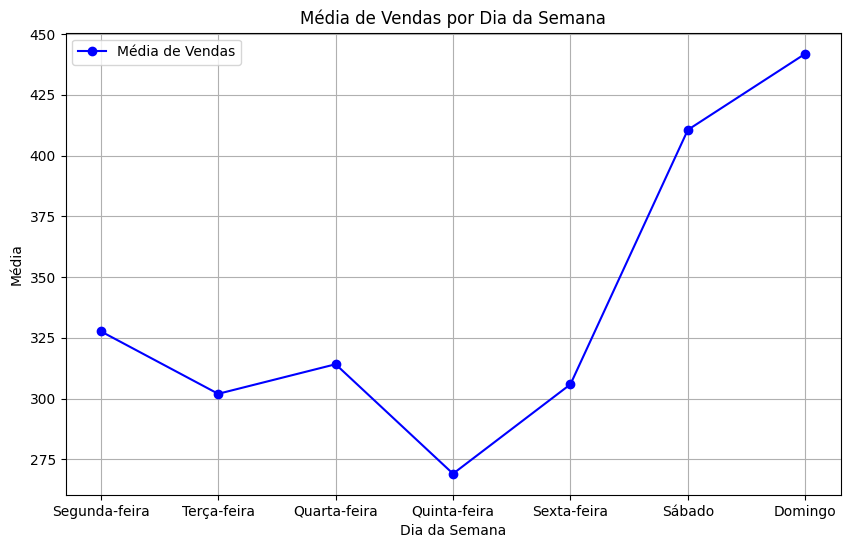

In [13]:
train_data['day_of_week'] = train_data['date'].dt.dayofweek

weekly_avg_sales = train_data.groupby('day_of_week')['sales'].mean()

days_of_week = ['Segunda-feira', 'Terça-feira', 'Quarta-feira', 'Quinta-feira', 'Sexta-feira', 'Sábado', 'Domingo']

plt.figure(figsize=(10, 6))
plt.plot(days_of_week, weekly_avg_sales, marker='o', linestyle='-', color='b', label='Média de Vendas')
plt.xlabel('Dia da Semana')
plt.ylabel('Média')
plt.title('Média de Vendas por Dia da Semana')
plt.legend()
plt.grid(True)
plt.show()


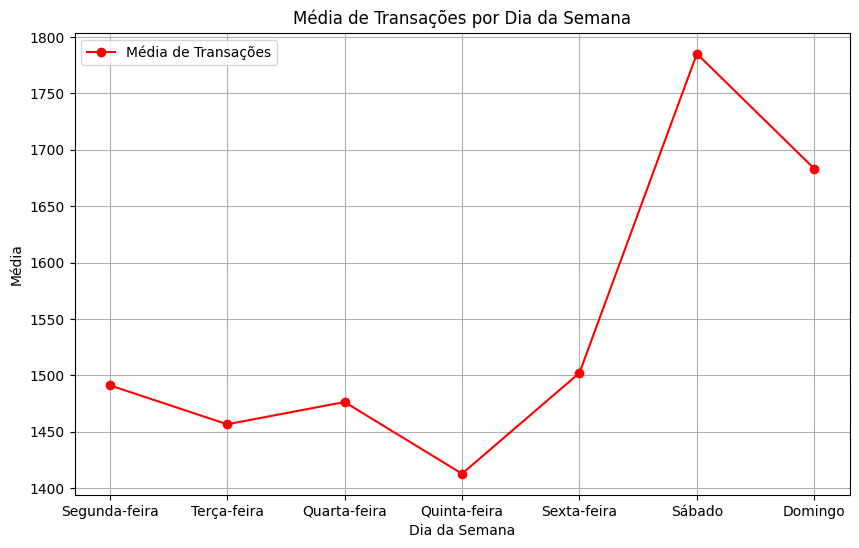

In [14]:
weekly_avg_transactions = train_data.groupby('day_of_week')['transactions'].mean()

plt.figure(figsize=(10, 6))
plt.plot(days_of_week, weekly_avg_transactions, marker='o', linestyle='-', color='r', label='Média de Transações')
plt.xlabel('Dia da Semana')
plt.ylabel('Média')
plt.title('Média de Transações por Dia da Semana')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
train_data

,id,date,store_nbr,family,sales,onpromotion,transactions,year_month,day_of_week
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,0.0,2013-01,1
1,1,2013-01-01,1,BABY CARE,0.000,0,0.0,2013-01,1
2,2,2013-01-01,1,BEAUTY,0.000,0,0.0,2013-01,1
3,3,2013-01-01,1,BEVERAGES,0.000,0,0.0,2013-01,1
4,4,2013-01-01,1,BOOKS,0.000,0,0.0,2013-01,1
...,...,...,...,...,...,...,...,...,...
2596369,2596369,2016-12-31,9,POULTRY,687.853,1,2998.0,2016-12,5
2596370,2596370,2016-12-31,9,PREPARED FOODS,100.405,1,2998.0,2016-12,5
2596371,2596371,2016-12-31,9,PRODUCE,3091.356,3,2998.0,2016-12,5
2596372,2596372,2016-12-31,9,SCHOOL AND OFFICE SUPPLIES,2.000,0,2998.0,2016-12,5


In [16]:
# Convert date to ordinal
train_data.loc[:, 'ordinal_date'] = train_data['date'].apply(lambda x: x.toordinal() - 734868)

# Get only month 
train_data.loc[:, 'month'] = train_data['date'].dt.month

# Change day_of_week to binary if saturaday or sunday
train_data.loc[:, 'weekend'] = train_data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)


train_data.drop(['year_month', 'day_of_week'], axis=1, inplace=True)

train_data

,id,date,store_nbr,family,sales,onpromotion,transactions,ordinal_date,month,weekend
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,0.0,1,1,0
1,1,2013-01-01,1,BABY CARE,0.000,0,0.0,1,1,0
2,2,2013-01-01,1,BEAUTY,0.000,0,0.0,1,1,0
3,3,2013-01-01,1,BEVERAGES,0.000,0,0.0,1,1,0
4,4,2013-01-01,1,BOOKS,0.000,0,0.0,1,1,0
...,...,...,...,...,...,...,...,...,...,...
2596369,2596369,2016-12-31,9,POULTRY,687.853,1,2998.0,1461,12,1
2596370,2596370,2016-12-31,9,PREPARED FOODS,100.405,1,2998.0,1461,12,1
2596371,2596371,2016-12-31,9,PRODUCE,3091.356,3,2998.0,1461,12,1
2596372,2596372,2016-12-31,9,SCHOOL AND OFFICE SUPPLIES,2.000,0,2998.0,1461,12,1


### See correlation - Pearson and Spearman

<Axes: >

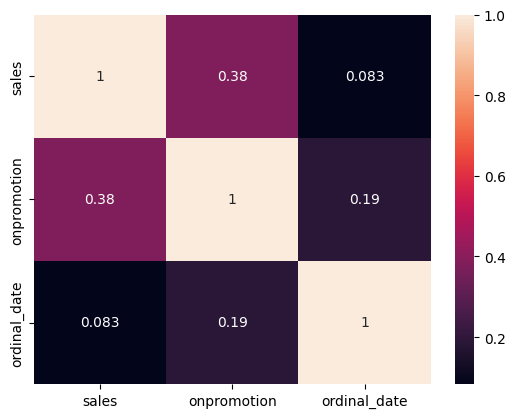

In [17]:
sns.heatmap(train_data[['sales', 'onpromotion','ordinal_date']].corr('pearson'), annot=True)

<Axes: >

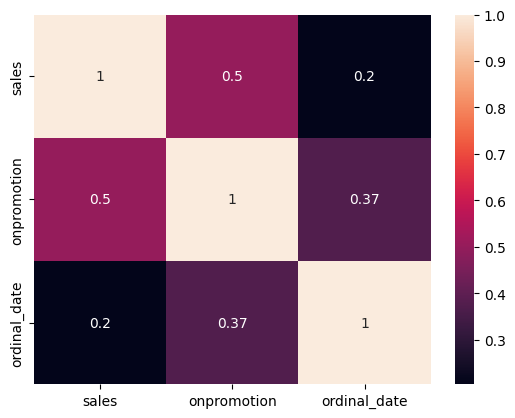

In [18]:
sns.heatmap(train_data[['sales', 'onpromotion','ordinal_date']].corr('spearman'), annot=True)

<Axes: >

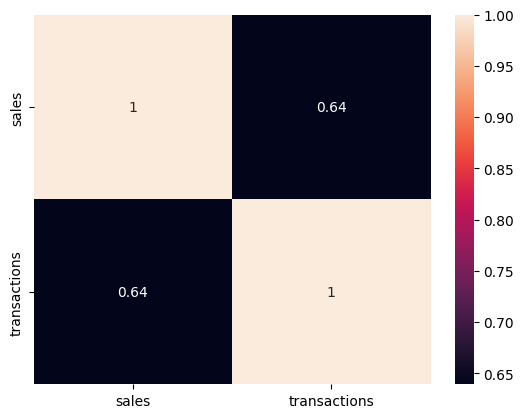

In [19]:
# See correlation between sum of sales and sum of transactions
sns.heatmap(train_data.groupby('date')[['sales', 'transactions']].sum().corr('pearson'), annot=True)

<Axes: >

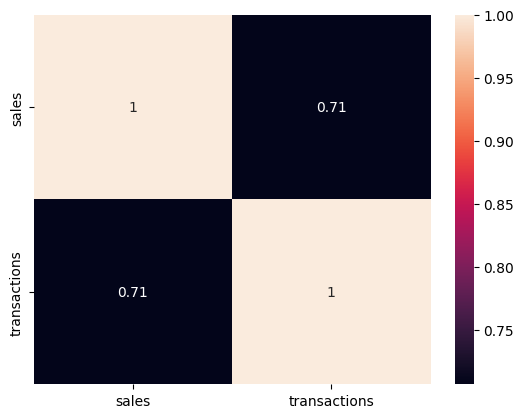

In [20]:
# See correlation between sum of sales and sum of transactions
sns.heatmap(train_data.groupby('date')[['sales', 'transactions']].sum().corr('spearman'), annot=True)

## See correlatin to previous sales

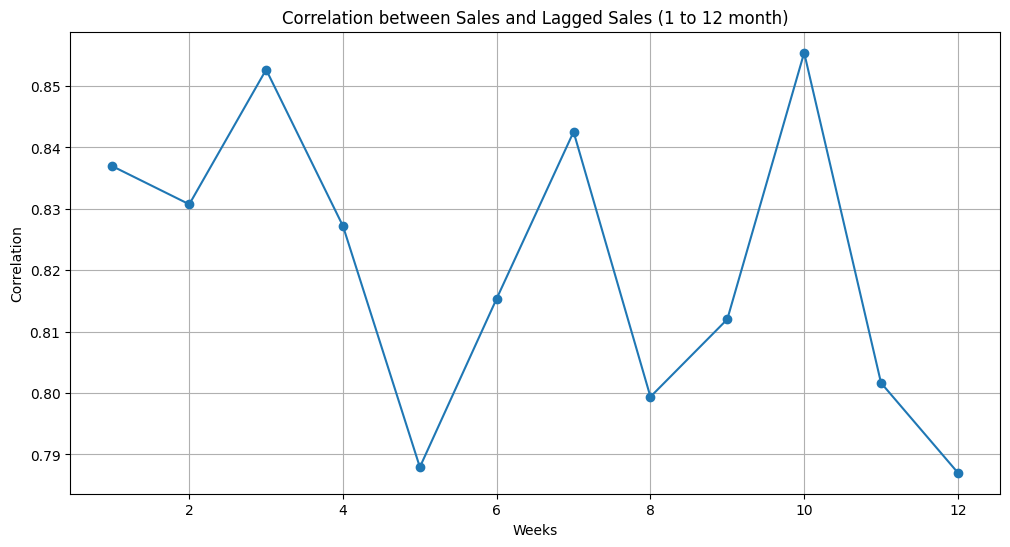

In [21]:
# Count the unique number of stores 
num_stores = train_data['store_nbr'].nunique()

# Supondo que train_data seja seu DataFrame
number_of_products = train_data['family'].nunique()

# Criar colunas de lag de 1 a 48 semanas
for month in range(1, 13):
    train_data[f'sales_lag_{month}_month'] = train_data['sales'].shift(month * 30 * number_of_products * num_stores)

# Calcular correlação entre 'sales' e cada coluna de lag
correlations = []
for month in range(1, 13):
    correlation = train_data['sales'].corr(train_data[f'sales_lag_{month}_month'])
    correlations.append(correlation)


# Fill NaN values with 0
train_data = train_data.fillna(0)

# Plotar as correlações
weeks = np.arange(1, 13)
plt.figure(figsize=(12, 6))
plt.plot(weeks, correlations, marker='o')
plt.xlabel('Weeks')
plt.ylabel('Correlation')
plt.title('Correlation between Sales and Lagged Sales (1 to 12 month)')
plt.grid(True)
plt.show()

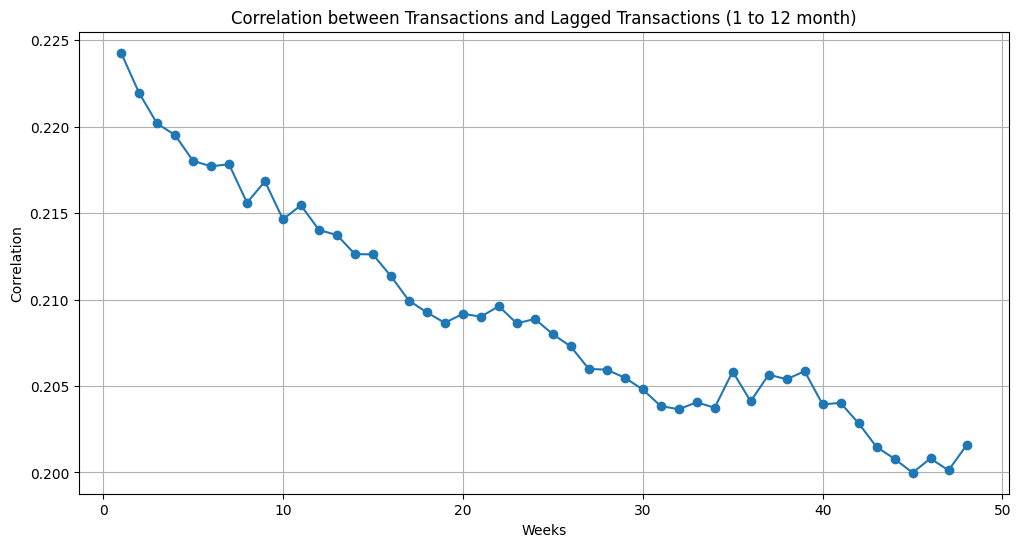

In [23]:
# Criar colunas de lag de 1 a 48 semanas
for month in range(1, 49):
    train_data[f'transactions_lag_{month}_month'] = train_data['sales'].shift(month * 7 * number_of_products * num_stores)

# Calcular correlação entre 'sales' e cada coluna de lag
correlations = []
for month in range(1, 49):
    correlation = train_data['transactions'].corr(train_data[f'transactions_lag_{month}_month'])
    correlations.append(correlation)


# Fill NaN values with 0
train_data = train_data.fillna(0)

# Plotar as correlações
weeks = np.arange(1, 49)
plt.figure(figsize=(12, 6))
plt.plot(weeks, correlations, marker='o')
plt.xlabel('Weeks')
plt.ylabel('Correlation')
plt.title('Correlation between Transactions and Lagged Transactions (1 to 12 month)')
plt.grid(True)
plt.show()

# Transform Data

In [22]:
# Drop columns different from 9, 18, 27, 36, 45
for week in range(1, 49):
    if week not in [9, 18, 27, 36, 45]:
        train_data.drop(f'sales_lag{week*7}', axis=1, inplace=True)

In [23]:
one_hot = OneHotEncoder(sparse_output=False)

family_one_hot = one_hot.fit_transform(train_data['family'].values.reshape(-1, 1))

# Concatenate the one hot encoded data with the original data
family_one_hot_df = pd.DataFrame(family_one_hot, columns=one_hot.get_feature_names_out())
train_data = pd.concat([train_data, family_one_hot_df], axis=1)

In [24]:
# Drop columns that are not needed
train_data = train_data.drop(columns=['id','family','date','store_nbr'])

In [25]:
train_data

,sales,onpromotion,transactions,ordinal_date,month,weekend,sales_lag63,sales_lag126,sales_lag189,sales_lag252,...,x0_MAGAZINES,x0_MEATS,x0_PERSONAL CARE,x0_PET SUPPLIES,x0_PLAYERS AND ELECTRONICS,x0_POULTRY,x0_PREPARED FOODS,x0_PRODUCE,x0_SCHOOL AND OFFICE SUPPLIES,x0_SEAFOOD
0,0.000,0,0.0,1,1,0,0.000,0.000,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000,0,0.0,1,1,0,0.000,0.000,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000,0,0.0,1,1,0,0.000,0.000,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000,0,0.0,1,1,0,0.000,0.000,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000,0,0.0,1,1,0,0.000,0.000,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2596369,687.853,1,2998.0,1461,12,1,391.292,437.685,458.064,504.476,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2596370,100.405,1,2998.0,1461,12,1,78.769,87.844,83.135,61.474,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2596371,3091.356,3,2998.0,1461,12,1,993.760,1065.133,1056.813,1079.388,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2596372,2.000,0,2998.0,1461,12,1,0.000,26.000,0.000,5.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Scaling the features

In [26]:
scaler = StandardScaler()
min_max_scaler = MinMaxScaler()

train_data = train_data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))


Y_train_data = train_data['sales']
X_train_data = train_data.drop(columns=['sales'])

X_scaled_train_data = min_max_scaler.fit(X_train_data)
X_scaled_train_data = min_max_scaler.transform(X_train_data)

X_scaled_train_data = pd.DataFrame(X_scaled_train_data, columns=X_train_data.columns)


In [27]:
X_scaled_train_data

,onpromotion,transactions,ordinal_date,month,weekend,sales_lag63,sales_lag126,sales_lag189,sales_lag252,sales_lag315,...,x0_MAGAZINES,x0_MEATS,x0_PERSONALCARE,x0_PETSUPPLIES,x0_PLAYERSANDELECTRONICS,x0_POULTRY,x0_PREPAREDFOODS,x0_PRODUCE,x0_SCHOOLANDOFFICESUPPLIES,x0_SEAFOOD
0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2596369,0.001350,0.358655,1.0,1.0,1.0,0.003137,0.003509,0.003673,0.005769,0.008267,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2596370,0.001350,0.358655,1.0,1.0,1.0,0.000632,0.000704,0.000667,0.000703,0.001867,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2596371,0.004049,0.358655,1.0,1.0,1.0,0.007968,0.008540,0.008474,0.012345,0.024806,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2596372,0.000000,0.358655,1.0,1.0,1.0,0.000000,0.000208,0.000000,0.000057,0.000065,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Testing models

In [28]:
train_data

,sales,onpromotion,transactions,ordinal_date,month,weekend,sales_lag63,sales_lag126,sales_lag189,sales_lag252,...,x0_MAGAZINES,x0_MEATS,x0_PERSONALCARE,x0_PETSUPPLIES,x0_PLAYERSANDELECTRONICS,x0_POULTRY,x0_PREPAREDFOODS,x0_PRODUCE,x0_SCHOOLANDOFFICESUPPLIES,x0_SEAFOOD
0,0.000,0,0.0,1,1,0,0.000,0.000,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000,0,0.0,1,1,0,0.000,0.000,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000,0,0.0,1,1,0,0.000,0.000,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000,0,0.0,1,1,0,0.000,0.000,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000,0,0.0,1,1,0,0.000,0.000,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2596369,687.853,1,2998.0,1461,12,1,391.292,437.685,458.064,504.476,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2596370,100.405,1,2998.0,1461,12,1,78.769,87.844,83.135,61.474,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2596371,3091.356,3,2998.0,1461,12,1,993.760,1065.133,1056.813,1079.388,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2596372,2.000,0,2998.0,1461,12,1,0.000,26.000,0.000,5.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [29]:
validation_data

,id,date,store_nbr,family,sales,onpromotion,transactions
2596374,2596374,2017-01-01,1,AUTOMOTIVE,0.000,0,0.0
2596375,2596375,2017-01-01,1,BABY CARE,0.000,0,0.0
2596376,2596376,2017-01-01,1,BEAUTY,0.000,0,0.0
2596377,2596377,2017-01-01,1,BEVERAGES,0.000,0,0.0
2596378,2596378,2017-01-01,1,BOOKS,0.000,0,0.0
...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,2155.0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,2155.0
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,2155.0
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,2155.0


In [30]:
validation_data['ordinal_date'] = validation_data['date'].apply(lambda x: x.toordinal() - 734868)

validation_data['month'] = validation_data['date'].dt.month

validation_data['day_of_week'] = validation_data['date'].dt.dayofweek

validation_data['weekend'] = validation_data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)



validation_data.drop(['day_of_week'], axis=1, inplace=True)


# Create columns of lag from weeks 9, 18, 27, 36, 45
for week in [9, 18, 27, 36, 45]:
    validation_data[f'sales_lag{week*7}'] = validation_data['sales'].shift(week*7*number_of_products * num_stores)

# Fill NaN values with 0
validation_data = validation_data.fillna(0)

one_hot = OneHotEncoder(sparse_output=False)

family_one_hot = one_hot.fit_transform(validation_data['family'].values.reshape(-1, 1))

# Concatenate the one hot encoded data with the original data
family_one_hot_df = pd.DataFrame(family_one_hot, columns=one_hot.get_feature_names_out(), index=validation_data.index)
validation_data = pd.concat([validation_data, family_one_hot_df], axis=1)

validation_data = validation_data.drop(columns=['id','family','date','store_nbr'])

validation_data = validation_data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

y_validation_data = validation_data['sales']
x_validation_data = validation_data.drop(columns=['sales'])

# Scaler used in train data
X_scaled_validation_data = min_max_scaler.transform(x_validation_data)

X_scaled_validation_data = pd.DataFrame(X_scaled_validation_data, columns=x_validation_data.columns)



In [31]:
models_to_test = []
rmsle_error = []

model_dict = {
    'K Neighbors Regressor': KNeighborsRegressor(n_jobs = -1),
    'Decision Tree Regressor': DecisionTreeRegressor(),
    'Random Forest Regressor': RandomForestRegressor(n_jobs = -1),
    'Adaboost Regressor': AdaBoostRegressor(),
}

# Creating a Function to append the cross validation scores of the algorithms
def input_scores(name, model, x_train, y_train, x_valid, y_valid):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_valid)
    y_pred = np.clip(y_pred, 0, None)  # Ensure no values are less than 0
    error = root_mean_squared_log_error(y_valid, y_pred)
    models_to_test.append(name)
    rmsle_error.append(error)


# Loop through the models and append the scores
i = 0
for name, model in model_dict.items():
    input_scores(name, model, X_scaled_train_data, Y_train_data, X_scaled_validation_data, y_validation_data)
    print(models_to_test[i], rmsle_error[i])
    i+=1

In [31]:
test_data = pd.read_csv('./data/test.csv')
test_data['date'] = pd.to_datetime(test_data['date'])


# Concat original and test data
lag_df = pd.concat([original_train_data, test_data], axis=0)

# Create columns of lag from weeks 9, 18, 27, 36, 45
for week in [9, 18, 27, 36, 45]:
    lag_df[f'sales_lag{week*7}'] = lag_df['sales'].shift(week*7*number_of_products * num_stores)
    lag_df[f'transactions_lag{week*7}'] = lag_df['transactions'].shift(week*7*number_of_products * num_stores)





In [32]:
lag_df

,id,date,store_nbr,family,sales,onpromotion,transactions,sales_lag63,transactions_lag63,sales_lag126,transactions_lag126,sales_lag189,transactions_lag189,sales_lag252,transactions_lag252,sales_lag315,transactions_lag315
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2013-01-01,1,BABY CARE,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2013-01-01,1,BEAUTY,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2013-01-01,1,BEVERAGES,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2013-01-01,1,BOOKS,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,NaN,1,NaN,285.335000,1723.0,298.363000,1825.0,378.531,1892.0,416.049,3077.0,312.849,1586.0
28508,3029396,2017-08-31,9,PREPARED FOODS,NaN,0,NaN,106.325000,1723.0,83.055000,1825.0,131.270,1892.0,139.891,3077.0,94.000,1586.0
28509,3029397,2017-08-31,9,PRODUCE,NaN,1,NaN,1084.579000,1723.0,1315.306000,1825.0,1143.013,1892.0,1792.190,3077.0,1053.866,1586.0
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9,NaN,2.000000,1723.0,0.000000,1825.0,1.000,1892.0,0.000,3077.0,2.000,1586.0


In [27]:
test_data = test_data[test_data.store_nbr == 44]
test_data = test_data.reset_index(drop=True)

test_data['date'] = pd.to_datetime(test_data['date'])


test_data['day_of_week'] = test_data['date'].dt.dayofweek

test_data['ordinal_date'] = test_data['date'].apply(lambda x: x.toordinal() - 734868)

test_data['month'] = test_data['date'].dt.month


# Create columns of lag from weeks 9, 18, 27, 36, 45
for week in [9, 18, 27, 36, 45]:
    test_data[f'sales_lag{week*7}'] = test_data['sales'].shift(week*7*number_of_products)


one_hot = OneHotEncoder(sparse_output=False)

family_one_hot = one_hot.fit_transform(test_data['family'].values.reshape(-1, 1))

# Concatenate the one hot encoded data with the original data
family_one_hot_df = pd.DataFrame(family_one_hot, columns=one_hot.get_feature_names_out())
test_data = pd.concat([test_data, family_one_hot_df], axis=1)

test_data = test_data.drop(columns=['id','family','date','store_nbr'])

test_data = test_data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

y_test_data = test_data['sales']
test_data = test_data.drop(columns=['sales'])

X_scaled_test_data = min_max_scaler.transform(test_data)

X_scaled_test_data = pd.DataFrame(X_scaled_test_data, columns=test_data.columns)

# Fill NaN values with 0
X_scaled_test_data = X_scaled_test_data.fillna(0)

for name, model in model_dict.items():
    model.fit(X_scaled_train_data, Y_train_data)
    pred = model.predict(X_scaled_test_data)
    print(f'{name} RMSLE: {root_mean_squared_log_error(y_test_data, pred)}')
    print(f'{name} RMSE: {np.sqrt(mean_squared_error(y_test_data, pred))}')


K Neighbors Regressor RMSLE: 0.5638927935481209
K Neighbors Regressor RMSE: 828.9657178585777
Decision Tree Regressor RMSLE: 1.1115450091055505
Decision Tree Regressor RMSE: 2351.0623332640025
Random Forest Regressor RMSLE: 0.8415338600872877
Random Forest Regressor RMSE: 1719.163809909523


In [ ]:
def preprocess_data(test_data, min_max_scaler, one_hot_encoder):
    
    # Converte a coluna de data para o formato datetime
    test_data['date'] = pd.to_datetime(test_data['date'])
    
    # Extrai informações da data
    test_data['day_of_week'] = test_data['date'].dt.dayofweek
    test_data['ordinal_date'] = test_data['date'].apply(lambda x: x.toordinal() - 734868)
    test_data['month'] = test_data['date'].dt.month
    
    # Número de produtos
    number_of_products = len(test_data['family'].unique())
    
    # Cria colunas de lag para as semanas 9, 18, 27, 36, 45
    for week in [9, 18, 27, 36, 45]:
        test_data[f'sales_lag{week*7}'] = test_data['sales'].shift(week*7*number_of_products)
    
    # Codificação one-hot para a coluna 'family'
    family_one_hot = one_hot_encoder.fit_transform(test_data['family'].values.reshape(-1, 1))
    family_one_hot_df = pd.DataFrame(family_one_hot, columns=one_hot_encoder.get_feature_names_out())
    
    # Concatena os dados codificados com os dados originais
    test_data = pd.concat([test_data, family_one_hot_df], axis=1)
    
    # Remove colunas desnecessárias
    test_data = test_data.drop(columns=['id', 'family', 'date', 'store_nbr'])
    
    # Renomeia colunas para remover caracteres indesejados
    test_data = test_data.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
    

    # if 'sales' in test_data.columns:
    if 'sales' in test_data.columns:
        y_test_data = test_data['sales']
        test_data = test_data.drop(columns=['sales'])
    
    # Normaliza os dados
    X_scaled_test_data = min_max_scaler.transform(test_data)
    X_scaled_test_data = pd.DataFrame(X_scaled_test_data, columns=test_data.columns)
    
    # Preenche valores NaN com 0
    X_scaled_test_data = X_scaled_test_data.fillna(0)
    
    return X_scaled_test_data, y_test_data

## Make submission

In [ ]:
submission_data = pd.read_csv('./data/test.csv')

train_data = pd.read_csv('./data/train.csv')

train_data['date'] = pd.to_datetime(train_data['date'])
test_data = train_data[train_data['date'].dt.year == 2017]

submission_data['sales'] = test_data[-1*submission_data.shape[0]:]['sales']
submission_data['transactions'] = test_data[-1*submission_data.shape[0]:]['transactions']

x_submission_data, y_submission_data = preprocess_data(submission_data, min_max_scaler, one_hot)

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- transactions
